In [1]:
import tonic
import torch
import numpy as np

In [2]:
train_dataset = tonic.datasets.NMNIST(save_to="/data/sweta_das/CV_data/nmnist", train=True)
test_dataset = tonic.datasets.NMNIST(save_to="/data/sweta_das/CV_data/nmnist", train=False)

In [3]:
import tonic.transforms as transforms

sensor_size = tonic.datasets.NMNIST.sensor_size

In [4]:
frame_transform = transforms.ToFrame(sensor_size=(34,34,2), n_time_bins=16)
denoise_transform = tonic.transforms.Denoise(filter_time=10000)

In [5]:

class MergePolarity:
    def __init__(self):
        pass

    def __call__(Self, x):
        return x[:, 0, :, :]

In [6]:
class PermuteChannels:
    def __call__(self, x):
        # If input is a NumPy array: (C, H, W)
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x)  # Convert to tensor
        return x.permute(1, 2, 0)  # (C, H, W) → (H, W, C)

In [7]:
transform = transforms.Compose([denoise_transform, frame_transform, MergePolarity(), PermuteChannels()])

train_dataset = tonic.datasets.NMNIST(
    save_to="../tutorials/data", train=True, transform=transform
)

test_dataset  = tonic.datasets.NMNIST(
    save_to="../tutorials/data", train=False, transform=transform
)

In [8]:
def compute_global_min_max(dataset):
    min_val, max_val = float('inf'), float('-inf')
    for i in range(len(dataset)):
        data, _ = dataset[i]
        data_min, data_max = data.min(), data.max()
        min_val = min(min_val, data_min)
        max_val = max(max_val, data_max)
    return min_val, max_val

global_min, global_max = compute_global_min_max(train_dataset)



In [9]:
global_min_int = int(global_min)
global_max_int = int(global_max)
global_min_int, global_max_int

(0, 13)

In [10]:
class NormalizeToZeroToOne:
    def __init__(self, min_val, max_val):
        self.min = min_val
        self.max = max_val

    def __call__(self, x):
        x = x.astype(np.float32)
        x = (x - self.min) / (self.max - self.min)  # [0, 1]
        # x = 2 * x - 1  # [-1, 1]
        return x

In [11]:
normalize_transform = NormalizeToZeroToOne(global_min_int, global_max_int)
mergePolarity_transform = MergePolarity()

transform = transforms.Compose([
    denoise_transform,
    frame_transform,
    mergePolarity_transform,
    normalize_transform,
    PermuteChannels()
])

In [12]:
train_dataset = tonic.datasets.NMNIST(
    save_to="/data/sweta_das/CV_data/nmnist", train=True, transform=transform
)

test_dataset  = tonic.datasets.NMNIST(
    save_to="/data/sweta_das/CV_data/nmnist", train=False, transform=transform
)

In [13]:
print(train_dataset[0][0].shape)
print(train_dataset[0][1])

torch.Size([34, 34, 16])
0


In [14]:
from torch.utils.data import DataLoader

batch_size = 32

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
testloader = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=False, num_workers=0, pin_memory=True)


In [15]:
data_iter = iter(trainloader)
images, labels = next(data_iter)

print("Train batch - images shape:", images.shape)
print("Train batch - labels shape:", labels.shape)

Train batch - images shape: torch.Size([32, 34, 34, 16])
Train batch - labels shape: torch.Size([32])


In [16]:
data_iter = iter(testloader)
images, labels = next(data_iter)

print("Train batch - images shape:", images.shape)
print("Train batch - labels shape:", labels.shape)

Train batch - images shape: torch.Size([64, 34, 34, 16])
Train batch - labels shape: torch.Size([64])


In [17]:
print("Number of training batches:", len(trainloader))
print("Number of test batches:", len(testloader))

print("Total training samples:", len(train_dataset))
print("Total test samples:", len(test_dataset))

Number of training batches: 1875
Number of test batches: 157
Total training samples: 60000
Total test samples: 10000


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [19]:
dt = 5
a = 0.25
aa = 0.5  
Vth = 0.2
tau = 0.35

In [20]:
class SpikeAct(torch.autograd.Function):
    """ 
        Implementation of the spiking activation function with an approximation of gradient.
    """
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        # if input = u > Vth then output = 1
        output = torch.gt(input, Vth) 
        return output.float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors 
        grad_input = grad_output.clone()
        # hu is an approximate func of df/du
        hu = abs(input) < aa
        hu = hu.float() / (2 * aa)
        return grad_input * hu

class LIFSpike(nn.Module):
    """
        Generates spikes based on LIF module. It can be considered as an activation function and is used similar to ReLU. The input tensor needs to have an additional time dimension, which in this case is on the last dimension of the data.
    """
    def __init__(self):
        super(LIFSpike, self).__init__()

    def forward(self, x):
        nsteps = x.shape[-1]
        u   = torch.zeros(x.shape[:-1] , device=x.device)
        out = torch.zeros(x.shape, device=x.device)
        for step in range(nsteps):
            u, out[..., step] = self.state_update(u, out[..., max(step-1, 0)], x[..., step])
        return out
    
    def state_update(self, u_t_n1, o_t_n1, W_mul_o_t1_n, tau=tau):
        u_t1_n1 = tau * u_t_n1 * (1 - o_t_n1) + W_mul_o_t1_n
        o_t1_n1 = SpikeAct.apply(u_t1_n1)
        return u_t1_n1, o_t1_n1

class MySpikeAct(SpikeAct):
    """
        Implementation of the spiking activation function with an approximation of gradient.
    """
    @staticmethod
    def forward(ctx, input):
        data, Vth = input
        ctx.save_for_backward(input)
        # if input = u > Vth then output = 1
        output = torch.gt(data, Vth)
        return output.float()

    @staticmethod
    def backward(ctx, grad_output):
        data, Vth, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # hu is an approximate func of df/du
        hu = abs(data) < aa
        hu = hu.float() / (2 * aa)
        return grad_input * hu


class MyLIFSpike(LIFSpike):
    """
        Generates spikes based on LIF module. It can be considered as an activation function and is used similar to ReLU. The input tensor needs to have an additional time dimension, which in this case is on the last dimension of the data.
    """

    def __init__(self):
        super(MyLIFSpike, self).__init__()

    def forward(self, input):
        x, Vth = input
        nsteps = x.shape[-1]
        u   = torch.zeros(x.shape[:-1] , device=x.device)
        out = torch.zeros(x.shape, device=x.device)
        for step in range(nsteps):
            u, out[..., step] = self.state_update(u, out[..., max(step-1, 0)], x[..., step], Vth)
        return out

    def state_update(self, u_t_n1, o_t_n1, W_mul_o_t1_n, Vth, tau=tau):
        u_t1_n1 = tau * u_t_n1 * (1 - o_t_n1) + W_mul_o_t1_n
        o_t1_n1 = MySpikeAct.apply([u_t1_n1, Vth])
        return u_t1_n1, o_t1_n1


In [21]:
class tdLinear(nn.Linear):
    def __init__(self, 
                in_features,
                out_features,
                bias=True,
                bn=None,
                spike=None):
        assert type(in_features) == int, 'inFeatures should not be more than 1 dimesnion. It was: {}'.format(in_features.shape)
        assert type(out_features) == int, 'outFeatures should not be more than 1 dimesnion. It was: {}'.format(out_features.shape)

        super(tdLinear, self).__init__(in_features, out_features, bias=bias)

        self.bn = bn
        self.spike = spike
        

    def forward(self, x):
        """
        x : (N,C,T)
        """        
        x = x.transpose(1, 2) # (N, T, C)
        y = F.linear(x, self.weight, self.bias)
        y = y.transpose(1, 2)# (N, C, T)
        
        if self.bn is not None:
            y = y[:,:,None,None,:]
            y = self.bn(y)
            y = y[:,:,0,0,:]
        if self.spike is not None:
            y = self.spike(y)
        return y

class tdConv(nn.Conv3d):
    def __init__(self, 
                in_channels, 
                out_channels,  
                kernel_size,
                stride=1,
                padding=0,
                dilation=1,
                groups=1,
                bias=True,
                bn=None,
                spike=None,
                is_first_conv=False):

        # kernel
        if type(kernel_size) == int:
            kernel = (kernel_size, kernel_size, 1)
        elif len(kernel_size) == 2:
            kernel = (kernel_size[0], kernel_size[1], 1)
        else:
            raise Exception('kernelSize can only be of 1 or 2 dimension. It was: {}'.format(kernel_size.shape))

        # stride
        if type(stride) == int:
            stride = (stride, stride, 1)
        elif len(stride) == 2:
            stride = (stride[0], stride[1], 1)
        else:
            raise Exception('stride can be either int or tuple of size 2. It was: {}'.format(stride.shape))

        # padding
        if type(padding) == int:
            padding = (padding, padding, 0)
        elif len(padding) == 2:
            padding = (padding[0], padding[1], 0)
        else:
            raise Exception('padding can be either int or tuple of size 2. It was: {}'.format(padding.shape))

        # dilation
        if type(dilation) == int:
            dilation = (dilation, dilation, 1)
        elif len(dilation) == 2:
            dilation = (dilation[0], dilation[1], 1)
        else:
            raise Exception('dilation can be either int or tuple of size 2. It was: {}'.format(dilation.shape))

        super(tdConv, self).__init__(in_channels, out_channels, kernel, stride, padding, dilation, groups,
                                        bias=bias)
        self.bn = bn
        self.spike = spike
        self.is_first_conv = is_first_conv

    def forward(self, x):
        x = F.conv3d(x, self.weight, self.bias,
                        self.stride, self.padding, self.dilation, self.groups)
        if self.bn is not None:
            x = self.bn(x)
        if self.spike is not None:
            x = self.spike(x)
        return x


class tdConvTranspose(nn.ConvTranspose3d):
    def __init__(self, 
                in_channels, 
                out_channels,  
                kernel_size,
                stride=1,
                padding=0,
                output_padding=0,
                dilation=1,
                groups=1,
                bias=True,
                bn=None,
                spike=None):

        # kernel
        if type(kernel_size) == int:
            kernel = (kernel_size, kernel_size, 1)
        elif len(kernel_size) == 2:
            kernel = (kernel_size[0], kernel_size[1], 1)
        else:
            raise Exception('kernelSize can only be of 1 or 2 dimension. It was: {}'.format(kernel_size.shape))

        # stride
        if type(stride) == int:
            stride = (stride, stride, 1)
        elif len(stride) == 2:
            stride = (stride[0], stride[1], 1)
        else:
            raise Exception('stride can be either int or tuple of size 2. It was: {}'.format(stride.shape))

        # padding
        if type(padding) == int:
            padding = (padding, padding, 0)
        elif len(padding) == 2:
            padding = (padding[0], padding[1], 0)
        else:
            raise Exception('padding can be either int or tuple of size 2. It was: {}'.format(padding.shape))

        # dilation
        if type(dilation) == int:
            dilation = (dilation, dilation, 1)
        elif len(dilation) == 2:
            dilation = (dilation[0], dilation[1], 1)
        else:
            raise Exception('dilation can be either int or tuple of size 2. It was: {}'.format(dilation.shape))


        # output padding
        if type(output_padding) == int:
            output_padding = (output_padding, output_padding, 0)
        elif len(output_padding) == 2:
            output_padding = (output_padding[0], output_padding[1], 0)
        elif len(output_padding) == 3:
            output_padding = output_padding
        else:
            raise Exception('output_padding can be either int or tuple of size 2 or tuple of size 3. It was: {}'.format(padding.shape))

        super().__init__(in_channels, out_channels, kernel, stride, padding, output_padding, groups,
                                        bias=bias, dilation=dilation)

        self.bn = bn
        self.spike = spike

    def forward(self, x):
        x = F.conv_transpose3d(x, self.weight, self.bias,
                        self.stride, self.padding, 
                        self.output_padding, self.groups, self.dilation)

        if self.bn is not None:
            x = self.bn(x)
        if self.spike is not None:
            x = self.spike(x)
        return x


class tdBatchNorm(nn.BatchNorm2d):
    """
        Implementation of tdBN. Link to related paper: https://arxiv.org/pdf/2011.05280. In short it is averaged over the time domain as well when doing BN.
    Args:
        num_features (int): same with nn.BatchNorm2d
        eps (float): same with nn.BatchNorm2d
        momentum (float): same with nn.BatchNorm2d
        alpha (float): an addtional parameter which may change in resblock.
        affine (bool): same with nn.BatchNorm2d
        track_running_stats (bool): same with nn.BatchNorm2d
    """
    def __init__(self, num_features, eps=1e-05, momentum=0.2, alpha=0.9, affine=True, track_running_stats=True):
        super(tdBatchNorm, self).__init__(
            num_features, eps, momentum, affine, track_running_stats)
        self.alpha = alpha

    def forward(self, input):
        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            if self.num_batches_tracked is not None:
                self.num_batches_tracked += 1
                if self.momentum is None:  # use cumulative moving average
                    exponential_average_factor = 1.0 / float(self.num_batches_tracked)
                else:  # use exponential moving average
                    exponential_average_factor = self.momentum

        # calculate running estimates
        if self.training:
            mean = input.mean([0, 2, 3, 4])
            # use biased var in train
            var = input.var([0, 2, 3, 4], unbiased=False)
            n = input.numel() / input.size(1)
            with torch.no_grad():
                self.running_mean = exponential_average_factor * mean\
                    + (1 - exponential_average_factor) * self.running_mean
                # update running_var with unbiased var
                self.running_var = exponential_average_factor * var * n / (n - 1)\
                    + (1 - exponential_average_factor) * self.running_var
        else:
            mean = self.running_mean
            var = self.running_var

        input = self.alpha * Vth * (input - mean[None, :, None, None, None]) / (torch.sqrt(var[None, :, None, None, None] + self.eps))
        if self.affine:
            input = input * self.weight[None, :, None, None, None] + self.bias[None, :, None, None, None]
        
        return input


In [22]:
class PSP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.tau_s = 2

    def forward(self, inputs):
        """
        inputs: (N, C, T)
        """
        syns = None
        syn = 0
        n_steps = inputs.shape[-1]
        for t in range(n_steps):
            syn = syn + (inputs[...,t] - syn) / self.tau_s
            if syns is None:
                syns = syn.unsqueeze(-1)
            else:
                syns = torch.cat([syns, syn.unsqueeze(-1)], dim=-1)

        return syns


class MembraneOutputLayer(nn.Module):
    """
    outputs the last time membrane potential of the LIF neuron with V_th=infty
    """
    def __init__(self, n_steps=None) -> None:
        super().__init__()
        if n_steps is None:
            n_steps = 16

        arr = torch.arange(n_steps-1,-1,-1)
        self.register_buffer("coef", torch.pow(0.8, arr)[None,None,None,None,:]) # (1,1,1,1,T)

    def forward(self, x):
        """
        x : (N,C,H,W,T)
        """
        out = torch.sum(x*self.coef, dim=-1)
        return out

class PosteriorBernoulliSTBP(nn.Module):
    def __init__(self, k=20) -> None:
        """
        modeling of q(z_t | x_<=t, z_<t)
        """
        super().__init__()
        self.channels = 32
        self.k = k
        self.n_steps = 16

        self.layers = nn.Sequential(
            tdLinear(self.channels*2,
                    self.channels*2,
                    bias=True,
                    bn=tdBatchNorm(self.channels*2, alpha=2), 
                    spike=LIFSpike()),
            tdLinear(self.channels*2,
                    self.channels*4,
                    bias=True,
                    bn=tdBatchNorm(self.channels*4, alpha=2),
                    spike=LIFSpike()),
            tdLinear(self.channels*4,
                    self.channels*k,
                    bias=True,
                    bn=tdBatchNorm(self.channels*k, alpha=2),
                    spike=LIFSpike())
        )
        self.register_buffer('initial_input', torch.zeros(1, self.channels, 1))# (1,C,1)

        self.is_true_scheduled_sampling = True

    def forward(self, x):
        """
        input: 
            x:(B,C,T)
        returns: 
            sampled_z:(B,C,T)
            q_z: (B,C,k,T) # indicates q(z_t | x_<=t, z_<t) (t=1,...,T)
        """
        x_shape = x.shape # (B,C,T)
        batch_size=x_shape[0]
        random_indices = []
        # sample z inadvance without gradient
        with torch.no_grad():
            z_t_minus = self.initial_input.repeat(x_shape[0],1,1) # z_<t z0=zeros:(B,C,1)
            for t in range(self.n_steps-1):
                inputs = torch.cat([x[...,:t+1].detach(), z_t_minus.detach()], dim=1) # (B,C+C,t+1) x_<=t and z_<t
                outputs = self.layers(inputs) #(B, C*k, t+1) 
                q_z_t = outputs[...,-1] # (B, C*k, 1) q(z_t | x_<=t, z_<t) 
                
                # sampling from q(z_t | x_<=t, z_<t)
                random_index = torch.randint(0, self.k, (batch_size*self.channels,)) \
                            + torch.arange(start=0, end=batch_size*self.channels*self.k, step=self.k) #(B*C,) select 1 from every k value
                random_index = random_index.to(x.device)
                random_indices.append(random_index)

                z_t = q_z_t.view(batch_size*self.channels*self.k)[random_index] # (B*C,)
                z_t = z_t.view(batch_size, self.channels, 1) #(B,C,1)

                z_t_minus = torch.cat([z_t_minus, z_t], dim=-1) # (B,C,t+2)

        z_t_minus = z_t_minus.detach() # (B,C,T) z_0,...,z_{T-1}
        q_z = self.layers(torch.cat([x, z_t_minus], dim=1)) # (B,C*k,T)
        
        # input z_t_minus again to calculate tdBN
        sampled_z = None
        for t in range(self.n_steps):
            
            if t == self.n_steps-1:
                # when t=T
                random_index = torch.randint(0, self.k, (batch_size*self.channels,)) \
                            + torch.arange(start=0, end=batch_size*self.channels*self.k, step=self.k)
                random_indices.append(random_index)
            else:
                # when t<=T-1
                random_index = random_indices[t]

            # sampling
            sampled_z_t = q_z[...,t].view(batch_size*self.channels*self.k)[random_index] # (B*C,)
            sampled_z_t = sampled_z_t.view(batch_size, self.channels, 1) #(B,C,1)
            if t==0:
                sampled_z = sampled_z_t
            else:
                sampled_z = torch.cat([sampled_z, sampled_z_t], dim=-1)
                
        q_z = q_z.view(batch_size, self.channels, self.k, self.n_steps)# (B,C,k,T)

        return sampled_z, q_z


class PriorBernoulliSTBP(nn.Module):
    def __init__(self, k=20) -> None:
        """
        modeling of p(z_t|z_<t)
        """
        super().__init__()
        self.channels = 32
        self.k = k
        self.n_steps = 16

        self.layers = nn.Sequential(
            tdLinear(self.channels,
                    self.channels*2,
                    bias=True,
                    bn=tdBatchNorm(self.channels*2, alpha=2), 
                    spike=LIFSpike()),
            tdLinear(self.channels*2,
                    self.channels*4,
                    bias=True,
                    bn=tdBatchNorm(self.channels*4, alpha=2),
                    spike=LIFSpike()),
            tdLinear(self.channels*4,
                    self.channels*k,
                    bias=True,
                    bn=tdBatchNorm(self.channels*k, alpha=2),
                    spike=LIFSpike())
        )
        self.register_buffer('initial_input', torch.zeros(1, self.channels, 1))# (1,C,1)


    def forward(self, z, scheduled=False, p=None):
        if scheduled:
            return self._forward_scheduled_sampling(z, p)
        else:
            return self._forward(z)
    
    def _forward(self, z):
        """
        input z: (B,C,T) # latent spike sampled from posterior
        output : (B,C,k,T) # indicates p(z_t|z_<t) (t=1,...,T)
        """
        z_shape = z.shape # (B,C,T)
        batch_size = z_shape[0]
        z = z.detach()

        z0 = self.initial_input.repeat(batch_size, 1, 1) # (B,C,1)
        inputs = torch.cat([z0, z[...,:-1]], dim=-1) # (B,C,T)
        outputs = self.layers(inputs) # (B,C*k,T)
        
        p_z = outputs.view(batch_size, self.channels, self.k, self.n_steps) # (B,C,k,T)
        return p_z

    def _forward_scheduled_sampling(self, z, p):
        """
        use scheduled sampling
        input 
            z: (B,C,T) # latent spike sampled from posterior
            p: float # prob of scheduled sampling
        output : (B,C,k,T) # indicates p(z_t|z_<t) (t=1,...,T)
        """
        z_shape = z.shape # (B,C,T)
        batch_size = z_shape[0]
        z = z.detach()

        z_t_minus = self.initial_input.repeat(batch_size,1,1) # z_<t, z0=zeros:(B,C,1)
        if self.training:
            with torch.no_grad():
                for t in range(self.n_steps-1):
                    if t>=5 and random.random() < p: # scheduled sampling                    
                        outputs = self.layers(z_t_minus.detach()) #binary (B, C*k, t+1) z_<=t
                        p_z_t = outputs[...,-1] # (B, C*k, 1)
                        # sampling from p(z_t | z_<t)
                        prob1 = p_z_t.view(batch_size, self.channels, self.k).mean(-1) # (B,C)
                        prob1 = prob1 + 1e-3 * torch.randn_like(prob1) 
                        z_t = (prob1>0.5).float() # (B,C)
                        z_t = z_t.view(batch_size, self.channels, 1) #(B,C,1)
                        z_t_minus = torch.cat([z_t_minus, z_t], dim=-1) # (B,C,t+2)
                    else:
                        z_t_minus = torch.cat([z_t_minus, z[...,t].unsqueeze(-1)], dim=-1) # (B,C,t+2)
        else: # for test time
            z_t_minus = torch.cat([z_t_minus, z[:,:,:-1]], dim=-1) # (B,C,T)

        z_t_minus = z_t_minus.detach() # (B,C,T) z_{<=T-1} 
        p_z = self.layers(z_t_minus) # (B,C*k,T)
        p_z = p_z.view(batch_size, self.channels, self.k, self.n_steps)# (B,C,k,T)
        return p_z

    def sample(self, batch_size=32):
        z_minus_t = self.initial_input.repeat(batch_size, 1, 1) # (B, C, 1)
        for t in range(self.n_steps):
            outputs = self.layers(z_minus_t) # (B, C*k, t+1)
            p_z_t = outputs[...,-1] # (B, C*k, 1)

            random_index = torch.randint(0, self.k, (batch_size*self.channels,)) \
                            + torch.arange(start=0, end=batch_size*self.channels*self.k, step=self.k) #(B*C,) pick one from k
            random_index = random_index.to(z_minus_t.device)

            z_t = p_z_t.view(batch_size*self.channels*self.k)[random_index] # (B*C,)
            z_t = z_t.view(batch_size, self.channels, 1) #(B,C,1)
            z_minus_t = torch.cat([z_minus_t, z_t], dim=-1) # (B,C,t+2)

        
        sampled_z = z_minus_t[...,1:] # (B,C,T)

        return sampled_z




In [23]:
class MMD_loss(nn.Module):
    def __init__(self, kernel_type='linear', kernel_mul=2.0, kernel_num=5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        self.kernel_type = kernel_type

    def guassian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0]) + int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        total0 = total.unsqueeze(0).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(
            int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2)
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i)
                          for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp)
                      for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def linear_mmd2(self, f_of_X, f_of_Y):
        loss = 0.0
        delta = f_of_X.float().mean(0) - f_of_Y.float().mean(0)
        loss = delta.dot(delta.T)
        return loss

    def forward(self, source, target):
        if self.kernel_type == 'linear':
            return self.linear_mmd2(source, target)
        elif self.kernel_type == 'rbf':
            batch_size = int(source.size()[0])
            kernels = self.guassian_kernel(
                source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
            XX = torch.mean(kernels[:batch_size, :batch_size])
            YY = torch.mean(kernels[batch_size:, batch_size:])
            XY = torch.mean(kernels[:batch_size, batch_size:])
            YX = torch.mean(kernels[batch_size:, :batch_size])
            loss = torch.mean(XX + YY - XY - YX)
            return loss


class SampledSpikeAct(torch.autograd.Function):
    """
        Implementation of the spiking activation function with an approximation of gradient.
    """

    @staticmethod
    def forward(ctx, input):
        random_sign = torch.rand_like(input, dtype=input.dtype).to(input.device)
        ctx.save_for_backward(input, random_sign)
        # if input = u > Vth then output = 1
        output = torch.gt(input, random_sign)
        return output.float()

    @staticmethod
    def backward(ctx, grad_output):
        input, random_sign = ctx.saved_tensors
        grad_input = grad_output.clone()
        # hu is an approximate func of df/du
        hu = abs(input - random_sign) < aa
        hu = hu.float() / (2 * aa)
        return grad_input * hu


class ESVAE(nn.Module):
    def __init__(self, device='cuda:0', distance_lambda=0.001, mmd_type='rbf'):
        super().__init__()

        in_channels = 1
        latent_dim = 64
        self.latent_dim = latent_dim
        self.n_steps = 16

        self.device = device
        self.distance_lambda = distance_lambda
        self.mmd_type = mmd_type

        self.k = 20

        hidden_dims = [32, 64, 128, 256, 512]
        self.hidden_dims = hidden_dims.copy()

        # Build Encoder
        modules = []
        is_first_conv = True
        for h_dim in hidden_dims:
            modules.append(
                tdConv(in_channels,
                       out_channels=h_dim,
                       kernel_size=3,
                       stride=2,
                       padding=1,
                       bias=True,
                       bn=tdBatchNorm(h_dim),
                       spike=LIFSpike(),
                       is_first_conv=is_first_conv)
            )
            in_channels = h_dim
            is_first_conv = False

        self.encoder = nn.Sequential(*modules)
        self.before_latent_layer = tdLinear(hidden_dims[-1] * 4,
                                            latent_dim,
                                            bias=True,
                                            bn=tdBatchNorm(latent_dim),
                                            spike=LIFSpike())

        self.prior = PriorBernoulliSTBP(self.k)

        self.posterior = PosteriorBernoulliSTBP(self.k)

        # Build Decoder
        modules = []

        self.decoder_input = tdLinear(latent_dim,
                                      hidden_dims[-1] * 4,
                                      bias=True,
                                      bn=tdBatchNorm(hidden_dims[-1] * 4),
                                      spike=LIFSpike())

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                tdConvTranspose(hidden_dims[i],
                                hidden_dims[i + 1],
                                kernel_size=3,
                                stride=2,
                                padding=1,
                                output_padding=0,
                                bias=True,
                                bn=tdBatchNorm(hidden_dims[i + 1]),
                                spike=LIFSpike())
            )
        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
            # tdConvTranspose(hidden_dims[-1],
            #                 hidden_dims[-1],
            #                 kernel_size=3,
            #                 stride=2,
            #                 padding=1,
            #                 output_padding=1,
            #                 bias=True,
            #                 bn=tdBatchNorm(hidden_dims[-1]),
            #                 spike=LIFSpike()),
            tdConvTranspose(hidden_dims[-1],
                            out_channels=1,
                            kernel_size=3,
                            stride=2,
                            padding=1,
                            output_padding=(1,1,0),
                            bias=True,
                            bn=None,
                            spike=None)
        )

        self.p = 0

        self.membrane_output_layer = MembraneOutputLayer()

        self.psp = PSP()

        self.sample_layer = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.Sigmoid()
        )

        self.mmd_loss = MMD_loss(kernel_type=self.mmd_type)

    def forward(self, x, scheduled=False):
        sampled_z_q, r_q, r_p = self.encode(x, scheduled)
        x_recon = self.decode(sampled_z_q)
        return x_recon, r_q, r_p, sampled_z_q

    def encode(self, x, scheduled=False, return_firing_rate=False):
        x = self.encoder(x)  # (N,C,H,W,T)
        x = torch.flatten(x, start_dim=1, end_dim=3)  # (N,C*H*W,T)
        latent_x = self.before_latent_layer(x)  # (N,latent_dim,T)

        sampled_z_q, r_q, r_p = self.gaussian_sample(latent_x, latent_x.shape[0])
        return sampled_z_q, r_q, r_p

    def decode(self, z):
        result = self.decoder_input(z)  # (N,C*H*W,T)
        result = result.view(result.shape[0], self.hidden_dims[-1], 2, 2, self.n_steps)  # (N,C,H,W,T)
        result = self.decoder(result)  # (N,C,H,W,T)
        result = self.final_layer(result)  # (N,C,H,W,T)
        out = result
        # out = torch.tanh(self.membrane_output_layer(result))
        return out

    def sample(self, batch_size=32):
        sampled_z_p, _, _ = self.gaussian_sample(batch_size=batch_size)
        sampled_x = self.decode(sampled_z_p)
        return sampled_x, sampled_z_p

    def gaussian_sample(self, latent_x=None, batch_size=None, mu=None, var=None):
        if latent_x is not None:
            sampled_z_n = torch.randn((batch_size, self.latent_dim)).to(self.device)  # (N, latent_dim)
            r_p = self.sample_layer(sampled_z_n)

            r_q = latent_x.mean(-1, keepdim=True).repeat((1, 1, self.n_steps))
            sampled_z_q = SampledSpikeAct.apply(r_q)

            r_q = latent_x.mean(-1)   # (N, latent_dim)

            return sampled_z_q, r_q, r_p
        else:
            sampled_z_n = torch.randn((batch_size, self.latent_dim)).to(self.device)
            # if mu is None and var is None:
            #     mu = self.mu
            #     var = self.var
            # var = var * torch.ones_like(sampled_p).to(self.device)  # (N, latent_dim)
            # mu = mu * torch.ones_like(sampled_p).to(self.device)  # (N, latent_dim)
            # sampled_p = mu + sampled_z_n * var
            r_p = self.sample_layer(sampled_z_n)
            r_p = r_p.unsqueeze(dim=-1).repeat((1, 1, self.n_steps))
            sampled_z_q = SampledSpikeAct.apply(r_p)
            return sampled_z_q, None, None

    def loss_function_mmd(self, input_img, recons_img, r_q, r_p):
        """
        r_q is q(z|x): (N,latent_dim)
        r_p is p(z): (N,latent_dim)
        """
        recons_loss = F.mse_loss(recons_img, input_img)
        mmd_loss = self.mmd_loss(r_q, r_p)
        loss = recons_loss + self.distance_lambda * mmd_loss
        return {'loss': loss, 'Reconstruction_Loss': recons_loss, 'Distance_Loss': mmd_loss}

    def weight_clipper(self):
        with torch.no_grad():
            for p in self.parameters():
                p.data.clamp_(-4, 4)

    def update_p(self, epoch, max_epoch):
        init_p = 0.1
        last_p = 0.3
        self.p = (last_p - init_p) * epoch / max_epoch + init_p


<h2>Classifier</h2>

In [242]:
base_model = ESVAE()
base_model = base_model.to('cuda:0')
base_model.load_state_dict(torch.load('esvae_v6_model.pt', weights_only=True))


<All keys matched successfully>

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ESVAEClassifier(nn.Module):
    def __init__(self, base_model: ESVAE, num_classes: int = 10, device='cuda:0'):
        super().__init__()

        # Use pretrained encoder and latent layer from ESVAE
        self.encoder = base_model.encoder
        self.before_latent_layer = base_model.before_latent_layer
        self.sample_layer = base_model.sample_layer
        self.device = device

        # Freeze encoder parameters
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.before_latent_layer.parameters():
            param.requires_grad = False
        for param in self.sample_layer.parameters():
            param.requires_grad = False

        self.n_steps = base_model.n_steps  # usually 16
        self.latent_dim = base_model.latent_dim  # usually 64

        # Classifier head on top of average latent representation over time
        self.classifier = nn.Sequential(

            tdLinear(self.latent_dim,
                                      128,
                                      bias=True,
                                      bn=tdBatchNorm(128),
                                      spike=LIFSpike()),
            tdLinear(128,
                                      256,
                                      bias=True,
                                      bn=tdBatchNorm(256),
                                      spike=LIFSpike()),
            tdLinear(256,
                                      512,
                                      bias=True,
                                      bn=tdBatchNorm(512),
                                      spike=LIFSpike()),
            
            tdLinear(512,
                                      256,
                                      bias=True,
                                      bn=tdBatchNorm(256),
                                      spike=LIFSpike()),
            tdLinear(256,
                                      128,
                                      bias=True,
                                      bn=tdBatchNorm(128),
                                      spike=LIFSpike()),
            tdLinear(128,
                                      64,
                                      bias=True,
                                      bn=tdBatchNorm(64),
                                      spike=LIFSpike()),
            tdLinear(64,
                                      10,
                                      bias=True,
                                      bn=tdBatchNorm(10),
                                      spike=LIFSpike())
        )

    def forward(self, x):
        x = self.encoder(x)  # shape: (N, C, H, W, T)
        x = torch.flatten(x, start_dim=1, end_dim=3)  # (N, C*H*W, T)
        latent_x = self.before_latent_layer(x)  # (N,latent_dim,T)

        sampled_z_q, r_q, r_p = self.gaussian_sample(latent_x, latent_x.shape[0])
        logits = self.classifier(sampled_z_q)  # (N, num_classes)
        
        return logits


    def gaussian_sample(self, latent_x=None, batch_size=None, mu=None, var=None):
        if latent_x is not None:
            sampled_z_n = torch.randn((batch_size, self.latent_dim)).to(self.device)  # (N, latent_dim)
            r_p = self.sample_layer(sampled_z_n)

            r_q = latent_x.mean(-1, keepdim=True).repeat((1, 1, self.n_steps))
            sampled_z_q = SampledSpikeAct.apply(r_q)

            r_q = latent_x.mean(-1)   # (N, latent_dim)

            return sampled_z_q, r_q, r_p
        else:
            sampled_z_n = torch.randn((batch_size, self.latent_dim)).to(self.device)
            # if mu is None and var is None:
            #     mu = self.mu
            #     var = self.var
            # var = var * torch.ones_like(sampled_p).to(self.device)  # (N, latent_dim)
            # mu = mu * torch.ones_like(sampled_p).to(self.device)  # (N, latent_dim)
            # sampled_p = mu + sampled_z_n * var
            r_p = self.sample_layer(sampled_z_n)
            r_p = r_p.unsqueeze(dim=-1).repeat((1, 1, self.n_steps))
            sampled_z_q = SampledSpikeAct.apply(r_p)
            return sampled_z_q, None, None


In [245]:
# Assuming esvae is your trained ESVAE model with loaded weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier_model = ESVAEClassifier(base_model=base_model, num_classes=10, device=device)
classifier_model.to(device)

# Example input
dummy_input = torch.randn(32, 1, 34, 34, 16).to(device)  # (batch, channel, height, width, time_steps)

# Forward pass
logits1, logits2 = classifier_model(dummy_input)


In [246]:
logits1.shape

torch.Size([32, 10])

In [247]:
logits2.shape

torch.Size([16, 32, 10])

In [257]:
logits1[7]

tensor([0., 0., 0., 0., 0., 0., 0., 2., 0., 0.], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [256]:
logits2[0].sum(-2)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       grad_fn=<SumBackward1>)

In [250]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


def compute_metrics(y_true, y_pred, average='macro'):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average=average)
    precision = precision_score(y_true, y_pred, average=average)
    recall = recall_score(y_true, y_pred, average=average)
    return acc, f1, precision, recall


In [252]:
def train(model, dataloader, optimizer, criterion, device='cuda:0'):
    model.train()
    all_preds = []
    all_labels = []
    total_loss = 0
    print('Train')
    i = 0
    for x, y in dataloader:
        if i%300 == 0:
            print(i)
        x, y = x.to(device), y.to(device)
        spike_input = x.unsqueeze(1)
        optimizer.zero_grad()
        logits = model(spike_input)  # (B, num_classes, T)
        # Sum spikes over time
        logits_sum = logits.sum(dim=-1)  # (B, num_classes)

        loss = criterion(logits_sum, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits_sum.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        i += 1

    acc, f1, precision, recall = compute_metrics(all_labels, all_preds)
    avg_loss = total_loss / len(dataloader)
    return avg_loss, acc, f1, precision, recall


@torch.no_grad()
def test(model, dataloader, criterion, device='cuda:0'):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    print('Test')
    i = 0
    for x, y in dataloader:
        if i%300 == 0:
            print(i)
        x, y = x.to(device), y.to(device)
        spike_input = x.unsqueeze(1)
        logits = model(spike_input)  # (B, num_classes, T)
        logits_sum = logits.sum(dim=-1)  # (B, num_classes)

        loss = criterion(logits_sum, y)

        preds = logits_sum.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

        total_loss += loss.item()
        i +=1

    acc, f1, precision, recall = compute_metrics(all_labels, all_preds)
    avg_loss = total_loss / len(dataloader)
    return avg_loss, acc, f1, precision, recall



In [253]:
num_epochs = 5

In [254]:
from torch.optim import Adam

classifier_model = ESVAEClassifier(base_model, num_classes=10).to('cuda:0')
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    train_loss, train_acc, train_f1, train_prec, train_rec = train(classifier_model, trainloader, optimizer, criterion)
    test_loss, test_acc, test_f1, test_prec, test_rec = test(classifier_model, testloader, criterion)

    print(f"Epoch {epoch+1}")
    print(f"Train: Loss={train_loss:.4f}, Acc={train_acc:.4f}, F1={train_f1:.4f}, Prec={train_prec:.4f}, Rec={train_rec:.4f}")
    print(f"Test : Loss={test_loss:.4f}, Acc={test_acc:.4f}, F1={test_f1:.4f}, Prec={test_prec:.4f}, Rec={test_rec:.4f}")


Train
0


AttributeError: 'tuple' object has no attribute 'sum'

In [258]:
# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
import random
import statistics
import tqdm

In [259]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ESVAEClassifier(nn.Module):
    def __init__(self, base_model: ESVAE, num_classes: int = 10, device='cuda:0', init_beta=0.9):
        super().__init__()

        # Use pretrained encoder and latent layer from ESVAE
        self.encoder = base_model.encoder
        self.before_latent_layer = base_model.before_latent_layer
        self.sample_layer = base_model.sample_layer
        self.device = device

        # Freeze encoder parameters
        for param in self.encoder.parameters():
            param.requires_grad = False
        for param in self.before_latent_layer.parameters():
            param.requires_grad = False
        for param in self.sample_layer.parameters():
            param.requires_grad = False

        self.n_steps = base_model.n_steps  # usually 16
        self.latent_dim = base_model.latent_dim  # usually 64

        self.spike_fn = surrogate.fast_sigmoid()

        self.lif1 = snn.Leaky(beta=init_beta, learn_beta=True, spike_grad=self.spike_fn)

        self.fc2 = nn.Linear(self.latent_dim, 128)
        self.lif2 = snn.Leaky(beta=init_beta, learn_beta=True, spike_grad=self.spike_fn)

        self.fc3 = nn.Linear(128, num_classes)
        self.lif3 = snn.Leaky(beta=init_beta, learn_beta=True, spike_grad=self.spike_fn)

    def forward(self, x):
        x = self.encoder(x)  # shape: (N, C, H, W, T)
        x = torch.flatten(x, start_dim=1, end_dim=3)  # (N, C*H*W, T)
        latent_x = self.before_latent_layer(x)  # (N,latent_dim,T)

        sampled_z_q, r_q, r_p = self.gaussian_sample(latent_x, latent_x.shape[0])
        batch_size = sampled_z_q.size(0)
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3  = self.lif2.init_leaky()

        spk3_record = []

        for t in range(self.n_steps):
            input_t = sampled_z_q[:, :, t]
            spk1, mem1 = self.lif1(input_t, mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)

            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3_record.append(spk3)

        spk3_record = torch.stack(spk3_record, dim=2)  # (B, num_classes, T)
        out = spk3_record.sum(dim=2)  # summed over time
        spk3_record = spk3_record.permute(2, 0, 1)
        return out, spk3_record


    def gaussian_sample(self, latent_x=None, batch_size=None, mu=None, var=None):
        if latent_x is not None:
            sampled_z_n = torch.randn((batch_size, self.latent_dim)).to(self.device)  # (N, latent_dim)
            r_p = self.sample_layer(sampled_z_n)

            r_q = latent_x.mean(-1, keepdim=True).repeat((1, 1, self.n_steps))
            sampled_z_q = SampledSpikeAct.apply(r_q)

            r_q = latent_x.mean(-1)   # (N, latent_dim)

            return sampled_z_q, r_q, r_p
        else:
            sampled_z_n = torch.randn((batch_size, self.latent_dim)).to(self.device)
            # if mu is None and var is None:
            #     mu = self.mu
            #     var = self.var
            # var = var * torch.ones_like(sampled_p).to(self.device)  # (N, latent_dim)
            # mu = mu * torch.ones_like(sampled_p).to(self.device)  # (N, latent_dim)
            # sampled_p = mu + sampled_z_n * var
            r_p = self.sample_layer(sampled_z_n)
            r_p = r_p.unsqueeze(dim=-1).repeat((1, 1, self.n_steps))
            sampled_z_q = SampledSpikeAct.apply(r_p)
            return sampled_z_q, None, None


In [260]:
# Assuming esvae is your trained ESVAE model with loaded weights
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier_model = ESVAEClassifier(base_model=base_model, num_classes=10, device=device)
classifier_model.to(device)

# Example input
dummy_input = torch.randn(64, 1, 34, 34, 16).to(device)  # (batch, channel, height, width, time_steps)

# Forward pass
logits1, logits2 = classifier_model(dummy_input)


In [261]:
logits1[23]

tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0.], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [262]:
logits2.shape

torch.Size([16, 64, 10])

In [263]:
logits1.shape

torch.Size([64, 10])

In [265]:
import torch
import torch.nn as nn
from snntorch import functional as SF
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Helper to compute metrics
def compute_metrics(output_spikes, labels):
    # Sum over time: (B, C, T) -> (B, C)
    spike_sum = output_spikes.sum(dim=0)
    preds = spike_sum.argmax(dim=-1).cpu()
    labels = labels.cpu()

    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)
    return acc, f1, precision, recall


# Training loop
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_metrics = []
    print('Train')
    i = 0
    for data, targets in dataloader:
        if i%300 == 0:
            print(i)
        data = data.to(device)            # shape: (B, C, H, W, T) or (B, input_dim, T)
        targets = targets.to(device)
        spike_input = data.unsqueeze(1)
        optimizer.zero_grad()
        logits, spike_record = model(spike_input)   # (B, C, T)
        loss = criterion(spike_record, targets)
        loss.backward()
        optimizer.step()

        acc, f1, precision, recall = compute_metrics(spike_record, targets)
        all_metrics.append((loss.item(), acc, f1, precision, recall))
        i += 1

    mean_metrics = torch.tensor(all_metrics).mean(dim=0)
    return {
        'loss': mean_metrics[0].item(),
        'accuracy': mean_metrics[1].item(),
        'f1': mean_metrics[2].item(),
        'precision': mean_metrics[3].item(),
        'recall': mean_metrics[4].item()
    }


# Evaluation loop
def test(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_metrics = []
    print('Test')
    i = 0
    with torch.no_grad():
        for data, targets in dataloader:
            if i%150 == 0:
                print(i)
            data = data.to(device)
            targets = targets.to(device)
            spike_input = data.unsqueeze(1)
            logits, spike_record = model(spike_input)
            loss = criterion(spike_record, targets)

            acc, f1, precision, recall = compute_metrics(spike_record, targets)
            all_metrics.append((loss.item(), acc, f1, precision, recall))
            i += 1

    mean_metrics = torch.tensor(all_metrics).mean(dim=0)
    return {
        'loss': mean_metrics[0].item(),
        'accuracy': mean_metrics[1].item(),
        'f1': mean_metrics[2].item(),
        'precision': mean_metrics[3].item(),
        'recall': mean_metrics[4].item()
    }


In [266]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ESVAEClassifier(base_model).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = SF.ce_rate_loss()
# Training
for epoch in range(5):
    train_metrics = train_one_epoch(model, trainloader, optimizer, criterion, device)
    test_metrics = test(model, testloader, criterion, device)

    print(f"Epoch {epoch+1}")
    print("Train:", train_metrics)
    print("Test :", test_metrics)


Train
0
300
600
900
1200
1500
1800
Test
0
150
Epoch 1
Train: {'loss': 1.7772259984970094, 'accuracy': 0.7825333333333333, 'f1': 0.7369743789106961, 'precision': 0.759087713246592, 'recall': 0.7735099447383892}
Test : {'loss': 1.6933142782016923, 'accuracy': 0.8430533439490446, 'f1': 0.27050113691222616, 'precision': 0.2877051293173207, 'recall': 0.25788381337848504}
Train
0
300
600
900
1200
1500
1800
Test
0
150
Epoch 2
Train: {'loss': 1.6965034048080445, 'accuracy': 0.8354666666666667, 'f1': 0.7986071190260133, 'precision': 0.8188948926300038, 'recall': 0.8260519274018163}
Test : {'loss': 1.662832957923792, 'accuracy': 0.853702229299363, 'f1': 0.2729202958992074, 'precision': 0.2897685169416155, 'recall': 0.2603669773624458}
Train
0
300
600
900
1200
1500
1800
Test
0
150
Epoch 3
Train: {'loss': 1.6739737121582032, 'accuracy': 0.8458833333333333, 'f1': 0.8123084665926384, 'precision': 0.8316946635668857, 'recall': 0.8386348123728123}
Test : {'loss': 1.6456506753423412, 'accuracy': 0.8755

In [274]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def testv2(model, dataloader, criterion, device):
    model.eval()
    all_metrics = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, targets in dataloader:
            data = data.to(device)
            targets = targets.to(device)
            spike_input = data.unsqueeze(1)
            logits, spike_record = model(spike_input)
            loss = criterion(spike_record, targets)

            # Aggregate spikes over time
            spike_sum = spike_record.sum(dim=0)  # (B, C)
            preds = spike_sum.argmax(dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
            all_metrics.append(loss.item())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Classification Report
    print("\n📊 Classification Report (Test Set):")
    # Classification Report
    print("\n📊 Classification Report (Test Set):")
    print(classification_report(all_labels, all_preds, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('NMNIST Test Dataset: Confusion Matrix')
    # Save the figure
    plt.savefig('confusion_matrix_test_data_nmnist.png', dpi=300, bbox_inches='tight')
    plt.show()


    acc = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    return {
        'loss': np.mean(all_metrics),
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }


📊 Classification Report (Test Set):

📊 Classification Report (Test Set):
              precision    recall  f1-score   support

           0     0.9279    0.9449    0.9363       980
           1     0.9434    0.9841    0.9633      1135
           2     0.9234    0.8992    0.9111      1032
           3     0.8603    0.8168    0.8380      1010
           4     0.7730    0.9328    0.8454       982
           5     0.8212    0.8341    0.8276       892
           6     0.9212    0.9269    0.9240       958
           7     0.8738    0.8755    0.8746      1028
           8     0.8471    0.7454    0.7930       974
           9     0.8169    0.7384    0.7756      1009

    accuracy                         0.8715     10000
   macro avg     0.8708    0.8698    0.8689     10000
weighted avg     0.8724    0.8715    0.8705     10000



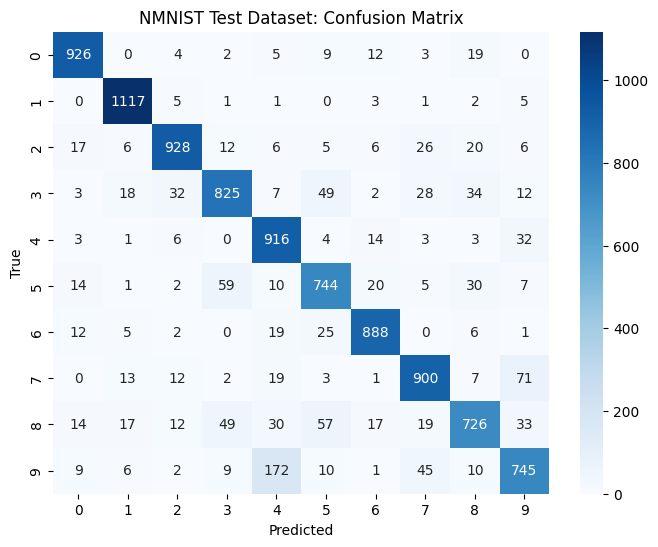

{'loss': 1.6361897181553446, 'accuracy': 0.8715, 'f1': 0.8689092836296307, 'precision': 0.8708085296082319, 'recall': 0.8698118530568747}


In [275]:
for epoch in range(1):
    metrics = testv2(model, testloader, criterion, device)
    print(metrics)

In [276]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def trainv2(model, dataloader, criterion, device):
    model.eval()
    all_metrics = []
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, targets in dataloader:
            data = data.to(device)
            targets = targets.to(device)
            spike_input = data.unsqueeze(1)
            logits, spike_record = model(spike_input)
            loss = criterion(spike_record, targets)

            # Aggregate spikes over time
            spike_sum = spike_record.sum(dim=0)  # (B, C)
            preds = spike_sum.argmax(dim=-1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())
            all_metrics.append(loss.item())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Classification Report
    print("\n📊 Classification Report (Train Set):")
    # Classification Report
    print("\n📊 Classification Report (Train Set):")
    print(classification_report(all_labels, all_preds, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('NMNIST Train Dataset: Confusion Matrix')
    plt.savefig('confusion_matrix_train_data_nmnist.png', dpi=300, bbox_inches='tight')
    plt.show()


    acc = (all_preds == all_labels).mean()
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    return {
        'loss': np.mean(all_metrics),
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
    }


📊 Classification Report (Train Set):

📊 Classification Report (Train Set):
              precision    recall  f1-score   support

           0     0.9566    0.9342    0.9452      5923
           1     0.9097    0.9696    0.9387      6742
           2     0.9197    0.8943    0.9068      5958
           3     0.8720    0.7912    0.8297      6131
           4     0.7530    0.9213    0.8287      5842
           5     0.8139    0.8537    0.8333      5421
           6     0.9356    0.9346    0.9351      5918
           7     0.8628    0.8964    0.8793      6265
           8     0.8398    0.7436    0.7888      5851
           9     0.8084    0.7119    0.7571      5949

    accuracy                         0.8665     60000
   macro avg     0.8672    0.8651    0.8643     60000
weighted avg     0.8684    0.8665    0.8656     60000



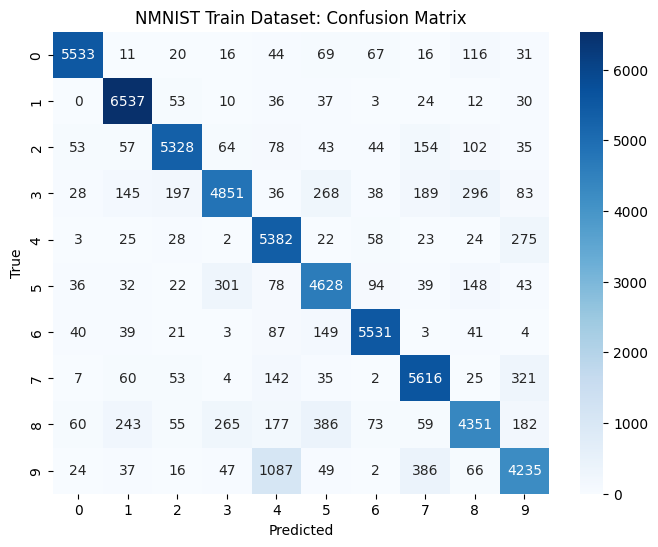

{'loss': 1.6405798479715983, 'accuracy': 0.8665333333333334, 'f1': 0.8642677040648025, 'precision': 0.8671524113764247, 'recall': 0.8650743014029884}


In [277]:
for epoch in range(1):
    metrics = trainv2(model, trainloader, criterion, device)
    print(metrics)